## Module Imports

In [108]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns

### Mount Google Drive to Google Colab

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

### **Identify datasets with NaN or None values**

In [59]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
db = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Week1_challenge_data_source(CSV).csv', na_values=['undefined','?', None])
db.head() # the fisrt five rows

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,42.0,5.0,23.0,44.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,37624.0,38787.0,1.823653e+09,Samsung,Samsung Galaxy A5 Sm-A520F,NaN,NaN,NaN,NaN,NaN,NaN,213.0,214.0,1545765.0,24420.0,1634479.0,1271433.0,3563542.0,137762.0,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,65.0,5.0,16.0,26.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,168.0,3560.0,1.365104e+09,Samsung,Samsung Galaxy J5 (Sm-J530),NaN,NaN,NaN,NaN,NaN,NaN,971.0,1022.0,1926113.0,7165.0,3493924.0,920172.0,629046.0,308339.0,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,NaN,NaN,6.0,9.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.361763e+09,Samsung,Samsung Galaxy A8 (2018),NaN,NaN,NaN,NaN,NaN,NaN,751.0,695.0,1684053.0,42224.0,8535055.0,1694064.0,2690151.0,672973.0,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,NaN,NaN,44.0,44.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,3330.0,37882.0,1.321510e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,207.0,644121.0,13372.0,9023734.0,2788027.0,1439754.0,631229.0,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,NaN,NaN,6.0,9.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.089009e+09,Samsung,Samsung Sm-G390F,NaN,NaN,NaN,NaN,NaN,NaN,607.0,604.0,862600.0,50188.0,6248284.0,1500559.0,1936496.0,173853.0,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


# Size of the dataset
### Columns of the dataset

In [60]:
# list of column  names
db.columns.tolist()

['Bearer Id',
 'Start',
 'Start ms',
 'End',
 'End ms',
 'Dur. (ms)',
 'IMSI',
 'MSISDN/Number',
 'IMEI',
 'Last Location Name',
 'Avg RTT DL (ms)',
 'Avg RTT UL (ms)',
 'Avg Bearer TP DL (kbps)',
 'Avg Bearer TP UL (kbps)',
 'TCP DL Retrans. Vol (Bytes)',
 'TCP UL Retrans. Vol (Bytes)',
 'DL TP < 50 Kbps (%)',
 '50 Kbps < DL TP < 250 Kbps (%)',
 '250 Kbps < DL TP < 1 Mbps (%)',
 'DL TP > 1 Mbps (%)',
 'UL TP < 10 Kbps (%)',
 '10 Kbps < UL TP < 50 Kbps (%)',
 '50 Kbps < UL TP < 300 Kbps (%)',
 'UL TP > 300 Kbps (%)',
 'HTTP DL (Bytes)',
 'HTTP UL (Bytes)',
 'Activity Duration DL (ms)',
 'Activity Duration UL (ms)',
 'Dur. (ms).1',
 'Handset Manufacturer',
 'Handset Type',
 'Nb of sec with 125000B < Vol DL',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 37500B < Vol UL',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Nb of sec with Vol DL < 6250B',
 'Nb of sec with Vol UL < 1250B',
 'Socia

### Number of columns

In [61]:
print(f"Number of columns: ", len(db.columns))

Number of columns:  55


### Number of data points and data size

In [62]:
print(f" There are {db.shape[0]} rows and {db.shape[1]} columns")

 There are 150001 rows and 55 columns


### Features/columns and their data type

In [63]:
db.dtypes

Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb

##Missing values percentile

In [64]:
# how many missing values exist or better still what is the % of missing values in the dataset?
def percent_missing(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 3), "%", "missing values.")

percent_missing(db)

The dataset contains 12.72 % missing values.


### Columns with missing values count

The Column "Nb of sec with 37500B < Vol UL" has maximum missing values of 130254 occurances

In [65]:
db.isna().sum() # missing values of each column

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [66]:
print ("Maximum missing values per column: ", np.max(db.isna().sum())) # print(db.isna().sum().max())

Maximum missing values per column:  130254


### Maximum values of each column

In [67]:
db.max()

Bearer Id                                   1.318654e+19
Start ms                                    9.990000e+02
End ms                                      9.990000e+02
Dur. (ms)                                   1.859336e+06
IMSI                                        2.140743e+14
MSISDN/Number                               8.823971e+14
IMEI                                        9.900120e+13
Avg RTT DL (ms)                             9.692300e+04
Avg RTT UL (ms)                             7.120000e+03
Avg Bearer TP DL (kbps)                     3.781600e+05
Avg Bearer TP UL (kbps)                     5.861300e+04
TCP DL Retrans. Vol (Bytes)                 4.294426e+09
TCP UL Retrans. Vol (Bytes)                 2.908226e+09
DL TP < 50 Kbps (%)                         1.000000e+02
50 Kbps < DL TP < 250 Kbps (%)              9.300000e+01
250 Kbps < DL TP < 1 Mbps (%)               1.000000e+02
DL TP > 1 Mbps (%)                          9.400000e+01
UL TP < 10 Kbps (%)            

### Top 10 Handsets used

In [68]:
db_hndset_count = db['Handset Type'].value_counts()
top_10_hndsets = db_hndset_count.head(10)
print("Most used handset types in Descending order:\n", db_hndset_count)
print("\n\nTop 10 handsets used: \n", top_10_hndsets)

Most used handset types in Descending order:
 Huawei B528S-23A                                           19752
Apple iPhone 6S (A1688)                                     9419
Apple iPhone 6 (A1586)                                      9023
Apple iPhone 7 (A1778)                                      6326
Apple iPhone Se (A1723)                                     5187
                                                           ...  
Tct Mobile Suzho. Alcatel One Touch Y580D                      1
Shenzhen Fortune. M-Ppas6                                      1
Wiko Global Sasu Wiko Ridge 4G                                 1
Hongkong Ipro Te. Ipro I9350 I9400 S3 Wave 3.5 Wave 4.0        1
Shenzhen Jeko Co. Blackview Bv5800 Pro                         1
Name: Handset Type, Length: 1395, dtype: int64


Top 10 handsets used: 
 Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
Apple iPhone 7 (A1778)           6326
Apple iPhone S

### Top 3 handset manufacturers

In [69]:
db_hndset_manufac_count = db['Handset Manufacturer'].value_counts()
top_3_manufact = db_hndset_manufac_count.head(3)
print("Dominant manufacturers in descending order:\n", db_hndset_manufac_count)
print("\n\nTop 3 manufacturers: \n", top_3_manufact)

Dominant manufacturers in descending order:
 Apple                               59565
Samsung                             40839
Huawei                              34423
Sony Mobile Communications Ab         980
Wiko Global Sasu                      747
                                    ...  
Pt. Arga Mas Lestari                    1
Doke Communication (Hk) Limited         1
Vastking Technology (Hk) Limited        1
Mobiwire Sas                            1
Shenzhen Gaoxinqi                       1
Name: Handset Manufacturer, Length: 169, dtype: int64


Top 3 manufacturers: 
 Apple      59565
Samsung    40839
Huawei     34423
Name: Handset Manufacturer, dtype: int64


### Manufacturer-Handset pairs

In [70]:
db_hndset_manufac_pair = db.value_counts(["Handset Manufacturer", "Handset Type"])
top_3_manufact_5_hndset = db_hndset_manufac_pair.head(3)
print("Manufacturers-handset pair:\n", top_3_manufact_5_hndset)
# print("\n\nTop 3 manufacturers: \n", top_3_manufact)
# db_manufac_hndset = db.groupby("Handset Manufacturer", "Handset Type")

Manufacturers-handset pair:
 Handset Manufacturer  Handset Type           
Huawei                Huawei B528S-23A           19752
Apple                 Apple iPhone 6S (A1688)     9419
                      Apple iPhone 6 (A1586)      9023
dtype: int64


### Data Aggregation with each column

In [71]:
db['Bearer Id'].value_counts() # Each BearerID occurances aggregated
# db.value_counts('Bearer Id') also works

1.304243e+19    16
1.304243e+19    10
1.304243e+19     9
1.304243e+19     9
1.304243e+19     9
                ..
7.349883e+18     1
7.349883e+18     1
1.311448e+19     1
7.349883e+18     1
7.349883e+18     1
Name: Bearer Id, Length: 134708, dtype: int64

### User (IMEI) Grouped and Agregated with Bearer Id(xDR session)

In [72]:
# db_user_xDR = db.groupby(["IMEI","Bearer Id"]).agg(session_count = ('Bearer Id', 'value_counts')) # it also works
db_user_xDR = db.groupby(["IMEI","Bearer Id"]).size()
db_user_xDR

IMEI          Bearer Id   
4.400152e+11  6.917538e+18    1
4.402138e+11  6.917538e+18    1
1.194901e+12  6.917538e+18    1
1.198201e+12  6.917538e+18    1
1.202601e+12  6.917538e+18    1
                             ..
9.900120e+13  7.277826e+18    1
              1.311448e+19    1
              1.304243e+19    1
              7.349883e+18    1
              1.304243e+19    1
Length: 147517, dtype: int64

### User(IMEI) Grouped and Aggregated with session duration

In [73]:
# db_user_Duration = db.groupby(["IMEI","Dur. (ms)"]).size()
# db_user_Duration = pd.pivot_table(db, values = "Dur. (ms)",index=["IMEI"],aggfunc=np.sum)
db_user_Duration = db.groupby(["IMEI","Dur. (ms)"]).size() #transform(sum)
db_user_Duration

IMEI          Dur. (ms)
4.400152e+11  74399.0      1
4.402138e+11  86399.0      1
1.194901e+12  87799.0      1
1.198201e+12  56344.0      1
1.202601e+12  18004.0      1
                          ..
9.900120e+13  17217.0      1
              84563.0      1
              9321.0       1
              100874.0     1
              32614.0      1
Length: 141917, dtype: int64

### User(IMEI) and Total UL(Upload) Grouped and Aggregated

In [74]:
db_user_UL_data = db.groupby(["IMEI","Total UL (Bytes)"]).size()
db_user_UL_data

IMEI          Total UL (Bytes)
4.400152e+11  39425114.0          1
4.402138e+11  24856321.0          1
1.194901e+12  44409558.0          1
1.198201e+12  54841047.0          1
1.202601e+12  38070613.0          1
                                 ..
9.900120e+13  27515078.0          1
              52510613.0          1
              60705879.0          1
              62463092.0          1
              47523160.0          1
Length: 149429, dtype: int64

### User(IMEI) and total download(DL) grouped and aggregated

In [75]:
db_user_DL_data = db.groupby(["IMEI","Total DL (Bytes)"]).size()
db_user_DL_data

IMEI          Total DL (Bytes)
4.400152e+11  196385061.0         1
4.402138e+11  133661264.0         1
1.194901e+12  858892798.0         1
1.198201e+12  791029122.0         1
1.202601e+12  795829234.0         1
                                 ..
9.900120e+13  857848384.0         1
              287049110.0         1
              334422603.0         1
              865582569.0         1
              483796100.0         1
Length: 149429, dtype: int64

### Data Volume for Social Media DL (Bytes)

In [76]:
db_user_DL_social_media = db.groupby(["IMEI","Social Media DL (Bytes)"]).size()
db_user_DL_social_media

IMEI          Social Media DL (Bytes)
4.400152e+11  2530606.0                  1
4.402138e+11  1301037.0                  1
1.194901e+12  3440702.0                  1
1.198201e+12  2155310.0                  1
1.202601e+12  356443.0                   1
                                        ..
9.900120e+13  2548908.0                  1
              1823780.0                  1
              1194056.0                  1
              1523973.0                  1
              3160354.0                  1
Length: 149429, dtype: int64

### Data volume for Social Media UL (Bytes)

In [77]:
db_user_UL_social_media = db.groupby(["IMEI","Social Media UL (Bytes)"]).size()
db_user_UL_social_media

IMEI          Social Media UL (Bytes)
4.400152e+11  23968.0                    1
4.402138e+11  10391.0                    1
1.194901e+12  21582.0                    1
1.198201e+12  47026.0                    1
1.202601e+12  40729.0                    1
                                        ..
9.900120e+13  19423.0                    1
              40173.0                    1
              11484.0                    1
              36687.0                    1
              47571.0                    1
Length: 149429, dtype: int64

### Data volume for YouTube DL (Bytes)

In [78]:
db_user_DL_Youtube = db.groupby(["IMEI","Youtube DL (Bytes)"]).size()
db_user_DL_Youtube

IMEI          Youtube DL (Bytes)
4.400152e+11  17663991.0            1
4.402138e+11  16138988.0            1
1.194901e+12  11564842.0            1
1.198201e+12  17902177.0            1
1.202601e+12  14930167.0            1
                                   ..
9.900120e+13  23028070.0            1
              7657831.0             1
              7758118.0             1
              21892427.0            1
              11712040.0            1
Length: 149429, dtype: int64

### Data volume for YouTube UL (Bytes)

In [79]:
db_user_UL_Youtube = db.groupby(["IMEI","Youtube UL (Bytes)"]).size()
db_user_UL_Youtube

IMEI          Youtube UL (Bytes)
4.400152e+11  10703865.0            1
4.402138e+11  5122393.0             1
1.194901e+12  12364791.0            1
1.198201e+12  19542058.0            1
1.202601e+12  5631939.0             1
                                   ..
9.900120e+13  3288163.0             1
              16255095.0            1
              18200855.0            1
              20132095.0            1
              17491066.0            1
Length: 149429, dtype: int64

### Data volume for Netflix DL (Bytes)

In [80]:
db_user_DL_Netflix = db.groupby(["IMEI","Netflix DL (Bytes)"]).size()
db_user_DL_Netflix

IMEI          Netflix DL (Bytes)
4.400152e+11  6289240.0             1
4.402138e+11  18158139.0            1
1.194901e+12  6415185.0             1
1.198201e+12  21142414.0            1
1.202601e+12  3775834.0             1
                                   ..
9.900120e+13  12108876.0            1
              13351462.0            1
              568035.0              1
              17069544.0            1
              6866986.0             1
Length: 149429, dtype: int64

### Data volume for Netflix UL (Bytes)

In [81]:
db_user_UL_Netflix = db.groupby(["IMEI","Netflix UL (Bytes)"]).size()
db_user_UL_Netflix

IMEI          Netflix UL (Bytes)
4.400152e+11  16570359.0            1
4.402138e+11  3929179.0             1
1.194901e+12  7003752.0             1
1.198201e+12  6731353.0             1
1.202601e+12  16166734.0            1
                                   ..
9.900120e+13  7786350.0             1
              20540669.0            1
              18503538.0            1
              10935676.0            1
              15478761.0            1
Length: 149429, dtype: int64

### Data volume for Google DL (Bytes)

In [82]:
db_user_DL_Google = db.groupby(["IMEI","Google DL (Bytes)"]).size()
db_user_DL_Google

IMEI          Google DL (Bytes)
4.400152e+11  9125569.0            1
4.402138e+11  8520422.0            1
1.194901e+12  8410141.0            1
1.198201e+12  5157701.0            1
1.202601e+12  5895854.0            1
                                  ..
9.900120e+13  6692349.0            1
              10320330.0           1
              8423513.0            1
              7989805.0            1
              2273925.0            1
Length: 149429, dtype: int64

### Data volume for Google UL (Bytes)

In [83]:
db_user_UL_Google = db.groupby(["IMEI","Google UL (Bytes)"]).size()
db_user_UL_Google

IMEI          Google UL (Bytes)
4.400152e+11  3608143.0            1
4.402138e+11  1514991.0            1
1.194901e+12  1073199.0            1
1.198201e+12  1790556.0            1
1.202601e+12  1209943.0            1
                                  ..
9.900120e+13  1614004.0            1
              3955033.0            1
              224804.0             1
              3664900.0            1
              692421.0             1
Length: 149429, dtype: int64

### Data volume for Email DL (Bytes)

In [84]:
db_user_DL_Email = db.groupby(["IMEI","Email DL (Bytes)"]).size()
db_user_DL_Email

IMEI          Email DL (Bytes)
4.400152e+11  989198.0            1
4.402138e+11  2585927.0           1
1.194901e+12  1483785.0           1
1.198201e+12  1641265.0           1
1.202601e+12  413901.0            1
                                 ..
9.900120e+13  3072288.0           1
              855847.0            1
              2540187.0           1
              3518168.0           1
              1412808.0           1
Length: 149429, dtype: int64

### Data volume for Email UL (Bytes)

In [85]:
db_user_UL_Email = db.groupby(["IMEI","Email UL (Bytes)"]).size()
db_user_UL_Email

IMEI          Email UL (Bytes)
4.400152e+11  144441.0            1
4.402138e+11  688283.0            1
1.194901e+12  580787.0            1
1.198201e+12  17994.0             1
1.202601e+12  422686.0            1
                                 ..
9.900120e+13  262886.0            1
              407553.0            1
              714363.0            1
              332090.0            1
              303858.0            1
Length: 149429, dtype: int64

### Data volume for Gaming DL (Bytes)

In [86]:
db_user_DL_Gaming = db.groupby(["IMEI","Gaming DL (Bytes)"]).size()
db_user_DL_Gaming

IMEI          Gaming DL (Bytes)
4.400152e+11  159786457.0          1
4.402138e+11  86956751.0           1
1.194901e+12  827578143.0          1
1.198201e+12  743030255.0          1
1.202601e+12  770457035.0          1
                                  ..
9.900120e+13  810397893.0          1
              253039860.0          1
              313938694.0          1
              813588652.0          1
              458369987.0          1
Length: 149429, dtype: int64

### Data volume for Gaming UL (Bytes)

In [87]:
db_user_UL_Gaming = db.groupby(["IMEI","Gaming UL (Bytes)"]).size()
db_user_UL_Gaming

IMEI          Gaming UL (Bytes)
4.400152e+11  1317702.0            1
4.402138e+11  4188367.0            1
1.194901e+12  11383285.0           1
1.198201e+12  11575761.0           1
1.202601e+12  3537598.0            1
                                  ..
9.900120e+13  8034861.0            1
              5811282.0            1
              14484574.0           1
              15139625.0           1
              8456271.0            1
Length: 149429, dtype: int64

### Data volume for Other DL

In [88]:
db_user_DL_Other = db.groupby(["IMEI","Other DL (Bytes)"]).size()
db_user_DL_Other

IMEI          Other DL (Bytes)
4.400152e+11  312057084.0         1
4.402138e+11  510810737.0         1
1.194901e+12  74601835.0          1
1.198201e+12  805940256.0         1
1.202601e+12  585417309.0         1
                                 ..
9.900120e+13  832539560.0         1
              451146519.0         1
              48646759.0          1
              338473361.0         1
              79836909.0          1
Length: 149429, dtype: int64

### Data Volume for Other UL

In [89]:
db_user_UL_Other = db.groupby(["IMEI","Other UL (Bytes)"]).size()
db_user_UL_Other

IMEI          Other UL (Bytes)
4.400152e+11  7056636.0           1
4.402138e+11  9402717.0           1
1.194901e+12  11982162.0          1
1.198201e+12  15136299.0          1
1.202601e+12  11060984.0          1
                                 ..
9.900120e+13  6509391.0           1
              5500808.0           1
              8566261.0           1
              12222019.0          1
              5053212.0           1
Length: 149429, dtype: int64

# Data Exploration

Use Mode method to fill the missing datapoints of all 'object' type features and Mean/Median methods for all numuric type features.
*   use Median method for skewed(negative/positive) numeric feature and 
*   use MEAN/Median for non-skewd/symetrical numeric feature


### Method selection based on data skewness

In [90]:
db.skew(axis=0)

Bearer Id                                     0.026666
Start ms                                      0.000968
End ms                                       -0.001163
Dur. (ms)                                     3.952609
IMSI                                         41.045956
MSISDN/Number                               332.155856
IMEI                                          1.071470
Avg RTT DL (ms)                              62.907828
Avg RTT UL (ms)                              28.457415
Avg Bearer TP DL (kbps)                       2.589437
Avg Bearer TP UL (kbps)                       4.503413
TCP DL Retrans. Vol (Bytes)                  15.951809
TCP UL Retrans. Vol (Bytes)                  84.113393
DL TP < 50 Kbps (%)                          -2.297803
50 Kbps < DL TP < 250 Kbps (%)                3.271453
250 Kbps < DL TP < 1 Mbps (%)                 4.566158
DL TP > 1 Mbps (%)                            5.370351
UL TP < 10 Kbps (%)                          -8.985016
10 Kbps < 

### Skewness visualization with histogram

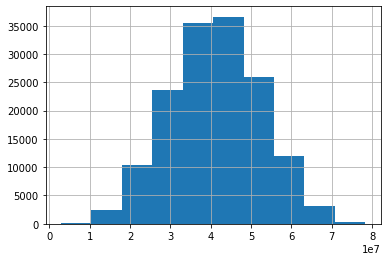

In [91]:
db['Total UL (Bytes)'].hist()

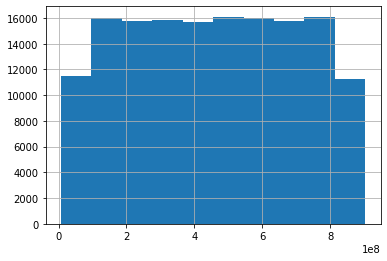

In [92]:
db['Total DL (Bytes)'].hist()

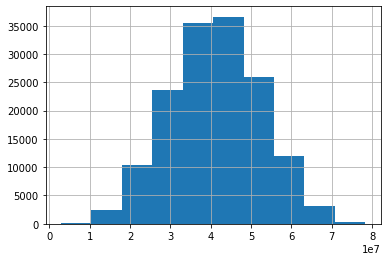

In [93]:
db['Total UL (Bytes)'].hist()

### Positively skewed parameter

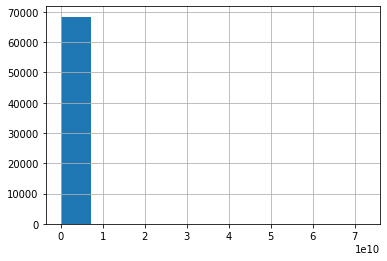

In [94]:
db['HTTP DL (Bytes)'].hist()

### Negatively skewwed parameter


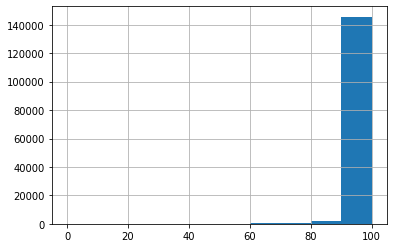

In [95]:
db['UL TP < 10 Kbps (%)'].hist()

### Data with sum of missing values in each column - revisited

In [96]:
db.isna().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

### Column data types - revisited

In [97]:
db.dtypes

Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb

### Utility function to fill missing values
* numeric missing values with mean method
* object type missing values with mode method

In [98]:
# fill numeric columns with ffill and bfill
"""
df[col].fillna(method='ffill') and df[col].fillna(method='bfill') or 
df[col].ffill(axis = 0) and df[col].bfill(axis = 0) fills the missing values with the value before/after it
"""
# fill missing numeric values with mean and object type values with mode
def fill_missing_values(df):
  for column in df.columns:
    if df[column].dtype == 'float64':
      df[column] = df[column].fillna(df[column].mean())
    elif df[column].dtypes == 'object':
      df[column] = df[column].fillna(df[column].mode()[0])
  return df


### Data with all missing values filled - zero null count



In [99]:
fill_missing_values(db).isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

### Other method of handling missing values - Interpolation
* We can use interpolation while working with time-series data because in time-series data we like to fill missing values with previous one or two values.
* It can be used to estimate unknown data points between two known data points.

##### Since we are not considering the time-series nature of the telecom data, we choose not to use interpolation here.

In [47]:
# db.interpolate(inplace=True)

## Transforming Data

**Scaling and Normalization**

##### Scaling - changing the range of your data 
##### Normalization, you're changing the shape of the distribution of your data.

#### Scaling

* This transforms data so that it fits within a specific scale, like 0-100 or 0-1. 
* It is important when we're using methods based on distance measures of data points like support vector machines (SVM) or k-nearest neighbors (KNN).
* We use the scaler method from sklearn.

#### Normalization

Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

* Normal distribution ("bell curve", Gaussian distribution) is a specific statistical distribution where a roughly equal observations fall above and below the mean
 * The mean and the median are the same, and there are more observations closer to the mean.

* In general, you'll normalize your data if you're going to be using a machine learning or statistics technique like LDA and Gaussian naive Bayes that assumes your data is normally distributed. Some examples of these include linear discriminant analysis (LDA) and Gaussian naive Bayes. (Pro tip: any method with "Gaussian" in the name probably assumes normality.)

* We usee the Normalizer method from sklearn



### Numeric value scalling

In [100]:
minmax_scaler = preprocessing.MinMaxScaler()
def scalling_numeric_values(df):
  col_values = []
  for column in df.columns:
    if df[column].dtype == 'float64':
      col_values.append(list(df[column].values))
  col_values_skaled = minmax_scaler.fit_transform(col_values)
  db_scaled = pd.DataFrame(col_values_skaled)
  return df



In [101]:
db_sklearn = fill_missing_values(db.copy())
scalling_numeric_values(db_sklearn)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0000,4/25/2019 14:35,662.00000,1.823652e+06,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,42.000000,5.000000,23.000000,44.000000,2.080991e+07,759658.664811,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,1.144710e+08,3.242301e+06,3.762400e+04,3.878700e+04,1.823653e+09,Samsung,Samsung Galaxy A5 Sm-A520F,989.699998,340.434395,810.837401,149.257052,965.464756,141.304812,213.000000,214.000000,1.545765e+06,24420.00000,1.634479e+06,1.271433e+06,3.563542e+06,137762.00000,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,2.780823e+08,1.434415e+07,1.717444e+08,8.814393e+06,3.674974e+07,3.088796e+08
1,1.311448e+19,4/9/2019 13:04,235.0000,4/25/2019 8:15,606.00000,1.365104e+06,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,65.000000,5.000000,16.000000,26.000000,2.080991e+07,759658.664811,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,1.144710e+08,3.242301e+06,1.680000e+02,3.560000e+03,1.365104e+09,Samsung,Samsung Galaxy J5 (Sm-J530),989.699998,340.434395,810.837401,149.257052,965.464756,141.304812,971.000000,1022.000000,1.926113e+06,7165.00000,3.493924e+06,9.201720e+05,6.290460e+05,308339.00000,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,6.087501e+08,1.170709e+06,5.269042e+08,1.505514e+07,5.380039e+07,6.533850e+08
2,1.311448e+19,4/9/2019 17:42,1.0000,4/25/2019 11:58,652.00000,1.361762e+06,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,109.795706,17.662883,6.000000,9.000000,2.080991e+07,759658.664811,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,1.144710e+08,3.242301e+06,0.000000e+00,0.000000e+00,1.361763e+09,Samsung,Samsung Galaxy A8 (2018),989.699998,340.434395,810.837401,149.257052,965.464756,141.304812,751.000000,695.000000,1.684053e+06,42224.00000,8.535055e+06,1.694064e+06,2.690151e+06,672973.00000,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,2.295846e+08,3.956300e+05,4.106926e+08,4.215763e+06,2.788364e+07,2.798073e+08
3,1.311448e+19,4/10/2019 0:31,486.0000,4/25/2019 7:36,171.00000,1.321509e+06,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,109.795706,17.662883,44.000000,44.000000,2.080991e+07,759658.664811,100.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,1.144710e+08,3.242301e+06,3.330000e+03,3.788200e+04,1.321510e+09,Apple,Huawei B528S-23A,989.699998,340.434395,810.837401,149.257052,965.464756,141.304812,17.000000,207.000000,6.441210e+05,13372.00000,9.023734e+06,2.788027e+06,1.439754e+06,631229.00000,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,7.995382e+08,1.084972e+07,7.490399e+08,1.279728e+07,4.332422e+07,8.460285e+08
4,1.311448e+19,4/12/2019 20:10,565.0000,4/25/2019 10:40,954.00000,1.089009e+06,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,109.795706,17.662883,6.000000,9.000000,2.080991e+07,759658.664811,100.000000,0.000000,0.0000

### Scaling between [0,1]

In [102]:
def scalling_numeric_values_0_1(df):
  for column in df.columns:
    if df[column].dtype == 'float64':
      df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(150001,1))
  return df

In [103]:
db_sklearn = fill_missing_values(db.copy())
scalling_numeric_values_0_1(db_sklearn)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,0.988506,4/4/2019 12:01,0.770771,4/25/2019 14:35,0.662663,0.980734,0.414307,7.248772e-08,0.355933,9.16456699548519E+015,0.000433,0.000702,0.000061,0.000751,0.004846,0.000261,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.001578,0.002173,0.000276,0.000268,0.980734,Samsung,Samsung Galaxy A5 Sm-A520F,0.012135,0.003974,0.013838,0.002933,0.014414,0.002831,0.000351,0.000353,0.431046,0.370730,0.142574,0.308498,0.993697,0.147114,0.681651,0.113631,0.352502,0.438681,0.329697,0.866255,0.203620,0.532304,0.448991,0.336846
1,0.988506,4/9/2019 13:04,0.235235,4/25/2019 8:15,0.606607,0.733164,0.414353,9.163195e-08,0.358701,L77566A,0.000671,0.000702,0.000042,0.000444,0.004846,0.000261,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.001578,0.002173,0.000001,0.000025,0.733164,Samsung,Samsung Galaxy J5 (Sm-J530),0.012135,0.003974,0.013838,0.002933,0.014414,0.002831,0.001606,0.001690,0.537109,0.108775,0.304792,0.223269,0.175407,0.329274,0.870515,0.868242,0.788437,0.782626,0.721744,0.070697,0.624705,0.909191,0.674934,0.721401
2,0.988506,4/9/2019 17:42,0.001001,4/25/2019 11:58,0.652653,0.731360,0.414194,1.809066e-07,0.353501,D42335A,0.001133,0.002481,0.000016,0.000154,0.004846,0.000261,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.001578,0.002173,0.000000,0.000000,0.731360,Samsung,Samsung Galaxy A8 (2018),0.012135,0.003974,0.013838,0.002933,0.014414,0.002831,0.001242,0.001149,0.469609,0.641020,0.744581,0.411045,0.750150,0.718667,0.848083,0.667798,0.756165,0.280002,0.272198,0.023889,0.486922,0.254587,0.331504,0.304394
3,0.988506,4/10/2019 0:31,0.486486,4/25/2019 7:36,0.171171,0.709627,0.414303,1.692516e-07,0.354263,T21824A,0.001133,0.002481,0.000116,0.000751,0.004846,0.000261,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.001578,0.002173,0.000024,0.000261,0.709627,Apple,Huawei B528S-23A,0.012135,0.003974,0.013838,0.002933,0.014414,0.002831,0.000026,0.000341,0.179615,0.203006,0.787213,0.676483,0.401474,0.674088,0.919559,0.688108,0.601682,0.049878,0.947947,0.655223,0.888074,0.772836,0.536111,0.936439
4,0.988506,4/12/2019 20:10,0.565566,4/25/2019 10:40,0.954955,0.584100,0.414303,1.119654e-07,0.354774,D88865A,0.001133,0.002481,0.000016,0.000154,0.004846,0.000261,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.001578,0.002173,0.000000,0.000000,0.584100,Samsung,Samsung Sm-G390F,0.012135,0.003974,0.013838,0.002933,0.014414,0.002831,0.001003,0.000998,0.240540,0.761925,0.545083,0.364093,0.539992,0.185656,0.656060,0.861480,0.736250,0.018862,0.625658,0.213165,0.652929,0.840054,0.472752,0.627361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14999

### Min values in each column

In [104]:
db.min()

Bearer Id                                                     6917537518543529984.0
Start                                                                4/10/2019 0:31
Start ms                                                                        0.0
End                                                                 4/24/2019 22:59
End ms                                                                          0.0
Dur. (ms)                                                                    7142.0
IMSI                                                              204047108489451.0
MSISDN/Number                                                         33601001722.0
IMEI                                                                 440015202000.0
Last Location Name                                            1.53279754934046E+017
Avg RTT DL (ms)                                                                 0.0
Avg RTT UL (ms)                                                             

### Max values in each column

In [105]:
db.max()

Bearer Id                                            13186541167134199808.0
Start                                                         4/9/2019 9:47
Start ms                                                              999.0
End                                                          4/30/2019 9:59
End ms                                                                999.0
Dur. (ms)                                                         1859336.0
IMSI                                                      214074303349628.0
MSISDN/Number                                             882397108489451.0
IMEI                                                       99001201327774.0
Last Location Name                                                  Y72157C
Avg RTT DL (ms)                                                     96923.0
Avg RTT UL (ms)                                                      7120.0
Avg Bearer TP DL (kbps)                                            378160.0
Avg Bearer T

### Difference between min and max values in each column

In [109]:
# db.max() - db.min()

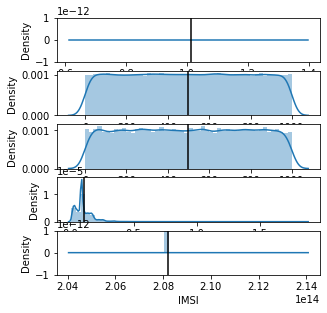

In [121]:
def plotting_count(df):
  num = df.select_dtypes(include=np.number)  # Get numeric columns
  n = num.shape[1] # Number of cols

  fig, axes = plt.subplots(5, 1, figsize=(12/2.54, 12/2.54))  # create subplots

  for ax, col in zip(axes, num):  # For each column...
      sns.distplot(num[col], ax=ax)   # Plot histogram
      ax.axvline(num[col].mean(), c='k')  # Plot mean

plotting_count(db)



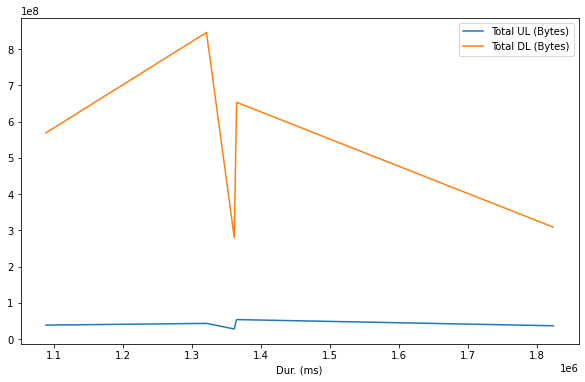

In [127]:
db.head().plot(x="Dur. (ms)", y=["Total UL (Bytes)", "Total DL (Bytes)"],
        kind="line", figsize=(10, 6))

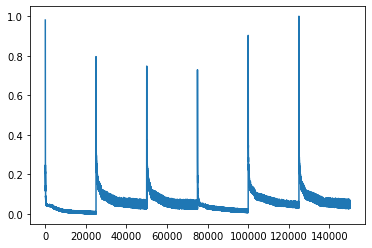

In [137]:
# db.head().plot()

def normalizer(df, col):
    # norm = Normalizer()
    # # normalize the exponential data with boxcox
    # normalized_data = norm.fit_transform(df)
    # # plot both together to compare
    # fig, ax=plt.subplots(1,2, figsize=(10, 6))
    # sns.histplot(df, ax=ax[0])
    # ax[0].set_title("Original Data")
    # sns.histplot(normalized_data[0], ax=ax[1])
    # ax[1].set_title("Normalized data")
    df[col].plot()

db_num=db_sklearn.select_dtypes(include=np.number)
# db_num
normalizer(db_num, "Dur. (ms)")

In [134]:
# check datatypes
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  float64
 1   Start                                     150001 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150001 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  float64
 7   MSISDN/Number                             150001 non-null  float64
 8   IMEI                                      150001 non-null  float64
 9   Last Location Name                        150001 non-null  object 
 10  Avg RTT DL (ms)     

In [ ]:
# df_clean.info()

In [ ]:
# df_clean['fix_age'].unique()

In [ ]:
   
# df_clean['age'] = [ ((int(i.split('-')[0]) + int(i.split('-')[1])) / 2)  for i in df_clean['fix_age']]

## Utility Functions

In [ ]:
# # Function to calculate missing values by column
# def missing_values_table(df):
#     # Total missing values
#     mis_val = df.isnull().sum()

#     # Percentage of missing values
#     mis_val_percent = 100 * df.isnull().sum() / len(df)

#     # dtype of missing values
#     mis_val_dtype = df.dtypes

#     # Make a table with the results
#     mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

#     # Rename the columns
#     mis_val_table_ren_columns = mis_val_table.rename(
#     columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

#     # Sort the table by percentage of missing descending
#     mis_val_table_ren_columns = mis_val_table_ren_columns[
#         mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
#     '% of Total Values', ascending=False).round(1)

#     # Print some summary information
#     print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
#         "There are " + str(mis_val_table_ren_columns.shape[0]) +
#           " columns that have missing values.")

#     # Return the dataframe with missing information
#     return mis_val_table_ren_columns

# def format_float(value):
#     return f'{value:,.2f}'

# def find_agg(df:pd.DataFrame, agg_column:str, agg_metric:str, col_name:str, top:int, order=False )->pd.DataFrame:
    
#     new_df = df.groupby(agg_column)[agg_column].agg(agg_metric).reset_index(name=col_name).\
#                         sort_values(by=col_name, ascending=order)[:top]
    
#     return new_df

# def convert_bytes_to_megabytes(df, bytes_data):
#     """
#         This function takes the dataframe and the column which has the bytes values
#         returns the megabytesof that value
        
#         Args:
#         -----
#         df: dataframe
#         bytes_data: column with bytes values
        
#         Returns:
#         --------
#         A series
#     """
    
#     megabyte = 1*10e+5
#     df[bytes_data] = df[bytes_data] / megabyte
    
#     return df[bytes_data]

# pd.options.display.float_format = format_float

## Extracting Data

In [ ]:
# db['readmitted'].value_counts()

In [ ]:
# percent_missing(df_clean)

In [ ]:
# missing_values_table(df_clean)

In [ ]:
# def map_readmitted(col):
#     readmitted_map = {'NO' : 'NO', '>30': 'YES', '<30': 'YES'}
#     return col.map(readmitted_map)
# # 
# db['fix_readmitted'] = map_readmitted(db['readmitted'])

In [ ]:
# unique encounter id
# db['change'].unique()

In [ ]:
# db.shape

In [ ]:
# pd.set_option('max_column', None)
# df = pd.read_excel("/content/drive/Shareddrives/10 Academy/Intensive training/Batch 6/Content-B6/Week-1/data/Week1_challenge_data_source.xlsx", engine = 'openpyxl')
# df.head()

### Mean and Mediam of some vital attributes

In [ ]:
columns = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
           'Google DL (Bytes)', 'Google UL (Bytes)','Total UL (Bytes)', 'Total DL (Bytes)']
db[columns].mean()

In [ ]:
db[columns].median()

### Univariate analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('darkgrid')
sns.set(font_scale=1.3)

### Non-graphical Univariat EDA

In [ ]:
db.describe()

In [ ]:
db.info()

In [ ]:
db.isna().sum()

In [ ]:
db.isnull().sum()

### Graphical Univariate EDA

In [ ]:
sns.histplot(x=columns[0], data =db)

In [ ]:
sns.histplot(x=columns[1], data =db)

In [ ]:
sns.histplot(x=db[columns]['Total UL (Bytes)'], data =db)

In [ ]:
sns.histplot(x=db[columns]['Total DL (Bytes)'], data =db)

### Bivariate analysis

# NB: The pivot_table() method took me too long to return the plot

---



In [ ]:
# pd.pivot_table(db,columns =['Total DL (Bytes)','Social Media DL (Bytes)'])#,aggfunc=[np.sum])

In [ ]:
sns.regplot(x='Total DL (Bytes)',y='Social Media DL (Bytes)',data=db)
# sns.countplot(x='Total DL (Bytes)',data=db) 
#boxplot, violinplot, stripplot, swarmplot, barplot also works

### Correlation Analysis

In [ ]:
# db['Total UL (Bytes)'].corr(method='pearson')
db.corr(method='pearson')